In [1]:
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np 
import pandas as pd
import spotipy
import matplotlib.pyplot as plt
import seaborn as sns
credentials = {
    'public' : 'e2b7e92cf8684577a314a8804b97337a', 
    'private': 'a847df678a5145d0a62381b255e4e4fd'
    }

client_credentials_manager = SpotifyClientCredentials(client_id=credentials['public'], client_secret=credentials['private'])
spotyCarlo = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
sns.set_style('ticks')

# Part 2 
## Popularity of a song
The Spotify for Developers API provide also another type of data: a track's popularity. Using the track "id" we can retrieve, with a little code, the actual popularity value for that particular track, and add these data into our dataset.

In [2]:
CreateNewDataset = False   # Set to false cause we have already run this and the dataset with popularity is ready, see dataframeV2.csv
if CreateNewDataset:
    dF = pd.read_csv('data\csvs\dataframeV1.csv', index_col=0)

    def addPop(id):
        return spotyCarlo.track(id)['popularity']

    dF.insert(15,'popularity',np.array(list(map(addPop,dF.iloc[:,11]))))
    dF.to_csv('data\csvs\dataframeV2.csv')

dF = pd.read_csv('data\csvs\dataframeV2.csv', index_col=0).drop(['id','uri'],axis=1)
X = dF[['popularity']]
X

,popularity
0,67
1,60
2,60
3,56
4,0
...,...
45,53
46,58
47,61
48,50


But how do you quantify the popularity of a song? According to Spotify, “The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past.”

we think this value is also used for music recommendation and to build the various "Trend" playlists.

So maybe it would be cool to look how things changs if we create a dataset with very popular songs, to se what they have in common or if there is any pattern. The "Top50_clean.csv" dataset contains a set of the currently Top50 most popular songs from any country we have found on spotify. Basically we merged together the data from "Top50 Italia", "Top50 France" "Top50 Australia" and so on and so forth.

Therefore now we have 2 dataset, the one with genres label, and the Top50 one. Let's now explore a few plots and visualizations.

## 2.1 - Explore the data.

Since predicting popularity is our north star, I’m curious to see what the popularity distribution is across the dataset.

DatasetV2: mean = 43 , mode = 0
Top50_all_countries: mean = 69 , mode = 73


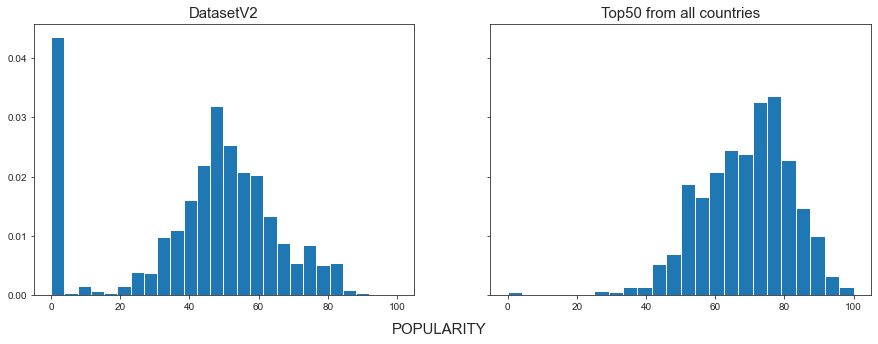

In [3]:
fig, ax = plt.subplots(ncols=2, figsize = (15,5),sharex = True, sharey = True)
dFpop = pd.read_csv('data\csvs\Top50_clean.csv', index_col=0).drop(['id','uri'],axis=1)
fig.supxlabel('POPULARITY',fontsize=15)
ax[0].set_title('DatasetV2',fontsize=15)
ax[0].hist(dF[['popularity']],density = True, bins = 24)
ax[1].set_title('Top50 from all countries',fontsize=15)
ax[1].hist(dFpop[['popularity']],density = True, bins = 24)
print('DatasetV2: mean =',int(round(dF[['popularity']].mean())),', mode =',int(dF[['popularity']].mode().iloc[0]))
print('Top50_all_countries: mean =',int(round(dFpop[['popularity']].mean())),', mode =',int(dFpop[['popularity']].mode().iloc[0]))


If we look at the leftmost histogram, the one about the almost "popularity unbiased" dataset, we see a right skewed distribution showing us how truly rare it is to have popular song. Looking at the right plot, with no surprise since we took the trending songs of various countries, we see a distribution centered near high values of popularity. 

Let's now have a look to some statistics of about popular songs:

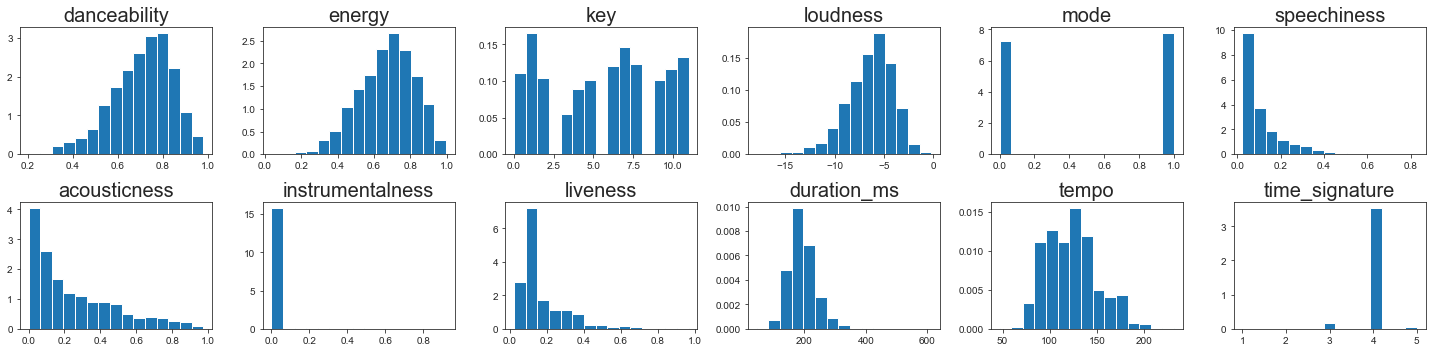

danceability        7.071826e-01
energy              6.689399e-01
loudness           -6.417846e+00
mode                5.162338e-01
speechiness         1.125265e-01
acousticness        2.493612e-01
instrumentalness    1.260278e-02
liveness            1.780320e-01
valence             5.677584e-01
tempo               1.233424e+02
duration_ms         1.928392e+02
popularity          6.870292e+01
artist_followers    4.688854e+06
dtype: float64


,tempo,duration_ms,time_signature
0,94.990,216.0,4.0
1,119.982,NaN,NaN
2,140.024,NaN,NaN


<Figure size 432x288 with 0 Axes>

In [4]:
dFpop['duration_ms'] = dFpop['duration_ms']/1000
feat = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms', 'tempo', 'time_signature']
_, ax = plt.subplots(ncols=len(feat)//2, nrows=2,figsize = (20,5)) 
for i in range(len(feat)//2):
    ax[0][i].set_title(feat[i], fontsize=20)
    ax[0][i].hist(dFpop.loc[:, feat[i]], density = True, label = feat[i], bins=15)
    ax[1][i].set_title(feat[i+6], fontsize=20)
    ax[1][i].hist(dFpop.loc[:, feat[i+6]], density = True, label = feat[i], bins=15)
plt.tight_layout()
plt.show()
plt.clf()
print(dFpop.mean().drop(['key','time_signature']))
dFpop.mode()[['tempo','duration_ms','time_signature']]

Since we have a little background knowledge about music, we have noticed a few interesting things :
* The most common duration among trending songs is more or less 3 minute and 30 seconds, that matches with the usual Radio's songs duration. From internet. "In general, a radio-ready song is one that is three minutes, give or take 30 seconds". The mean is indeed around 3 minutes.

* We have 3 modes for the Tempo: 95 bpm, 120 bmp and 140 bpm. Those are indeed the most used Tempo in Western music. If we want to make a (statistically insignificant) example, "Shape of you" by Ed Sheeran, "Sweet Child of Mine" by Guns N' Roses and "Beat It" by Michael Jackson are played with 95,120 and 140 bpm respectively, according to a bunch of websites.

* A very common time signature is 4/4, which in music theory is indeed the basic and default time signature, also the easiest one to play and follows instrumentically.

* People like high-energy songs, better if they can dance on it (see danceability and energy mean), while they don't give much attention to vocal-free and acoustic pieces (see acousticness and instrumentalness)

A fair question now is: is there any connection between our features and the popolarity of a song? Well, as initial guess (spoiler alert) we don't expect too much dependeces since how much a track will be famous depends a lot about external factors, as the current fashion, events happening in the world, artist's importance and reputation, social-media stuff and advertisment and so on. But let's see if we can come up with something notable.

First of all, let’s look at a correlation table to identify some baseline correlations between our many X variables. To do so we merge our two datasets onto one and see the results.

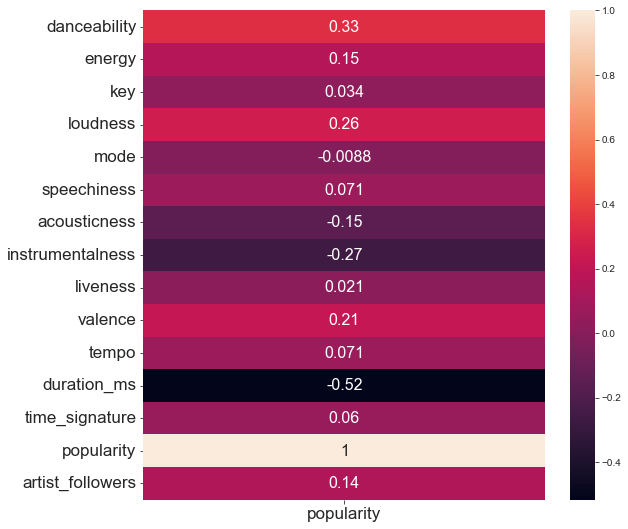

(2614, 15)

In [5]:
mergeDF = pd.concat([dF.drop('label',axis=1),dFpop]).drop_duplicates()
corr = mergeDF.corr()
x = corr[['popularity']]
fig,ax = plt.subplots(figsize=(9,9))
img = sns.heatmap(x,annot=True,annot_kws={'size':16})
img.set_yticklabels(img.get_ymajorticklabels(), fontsize = 17)
img.set_xticklabels(img.get_xmajorticklabels(), fontsize = 17)
plt.show()
mergeDF.shape

As expected, we can't see any strong correlation, the best results come with *danceability*, *loudness*, *instrumentalness* and *duration*, the latter is anticorrelated with a coefficient of 0.52.

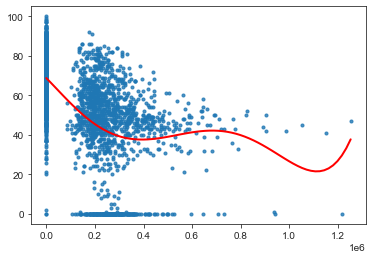

In [9]:
from GLM.LinearRegression import LinearRegression
step = 1
#fig, ax = plt.subplots(1,4,figsize=(25,5))
feat = ['duration_ms','danceability', 'loudness', 'instrumentalness']
LR = LinearRegression(15)
LR.fit(mergeDF[[feat[0]]][::step],mergeDF[['popularity']][::step])
LR.plotModel()
#for i in range(4):
    #ax[i].scatter(mergeDF[feat[i]][::step],mergeDF[['popularity']][::step])
    #ax[i].set_xlabel(feat[i],fontsize = 15)
    #ax[i].set_ylabel('Popularity',fontsize=15)
    
